In [58]:
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib notebook

Path.ls = lambda x: [o for o in x.iterdir()]

In [2]:
data_dirname = Path('../data/raw/')
processed_dirname = Path('../data/processed')
processed_dirname.mkdir(exist_ok=True, parents=True)

In [3]:
def print_df_stats(df: pd.DataFrame):
    """
    Print some basic info about the dataframe.
    """
    count = df.shape[0]  # n rows
    n_latex_equations = df['latex'].apply(len)
    n_latex_equations = n_latex_equations.sum()  # count the total number of latex equations
    print(f'{count} rows from with {n_latex_equations} latex equations.')


def combine_data_from_sources(file_type: str):
    """
    Find all of the .csv files in the data directory and combine them all together into a large dataframe.
    Assign a new column which tells me which forum each row came from, i.e. math, astronomy, etc.
    Assign a new column which tells me what kind of text this is, i.e. Post, Comment, etc.
    Useful when working with more than one stack exchange forum.
    """
    assert file_type in ('Posts', 'Comments')
    df_chunks = []
    for data_dir in data_dirname.rglob('*.com'):
        for json_filename in data_dir.rglob(f'{file_type}.json'):
            file_type = json_filename.with_suffix('').name  # Posts, Comments, etc.
            df = pd.read_json(json_filename)
            df['source'] = data_dir.name
            df['type'] = file_type
            print(json_filename)
            print_df_stats(df)
            df_chunks.append(df)
            save_dirname = processed_dirname/data_dir.name
            save_dirname.mkdir(exist_ok=True, parents=True)
            df.to_json(save_dirname/json_filename.name)
    df = pd.concat(df_chunks, axis=0, sort=False, ignore_index=True)
    return df

In [5]:
file_type = 'Posts'
posts = combine_data_from_sources(file_type)
posts.to_csv(processed_dirname/'Posts.csv')

../data/raw/physics.stackexchange.com/Posts.json
345199 rows from with 1339195 latex equations.
../data/raw/chemistry.stackexchange.com/Posts.json
66387 rows from with 198968 latex equations.
../data/raw/biology.stackexchange.com/Posts.json
48853 rows from with 12554 latex equations.


In [6]:
file_type = 'Comments'
comments = combine_data_from_sources(file_type)
comments.to_csv(processed_dirname/'Comments.csv')

../data/raw/physics.stackexchange.com/Comments.json
675300 rows from with 248766 latex equations.
../data/raw/chemistry.stackexchange.com/Comments.json
108799 rows from with 22883 latex equations.
../data/raw/biology.stackexchange.com/Comments.json
84776 rows from with 1154 latex equations.


In [38]:
def row_to_labeled_equation(row: pd.Series):
    for equation in row['latex']:
        yield {
            'source': row['source'],
            'post_id': row['Id'],
            'score': row['Score'],
            'user_id': row.get('UserId', row.get('OwnerUserId')),
            'type': row['type'],
            'equation': equation

        }

In [39]:
equations = []
_ = comments.apply(lambda row: [equations.append(e) for e in row_to_labeled_equation(row)], axis=1)
_ = posts.apply(lambda row: [equations.append(e) for e in row_to_labeled_equation(row)], axis=1)

In [40]:
eq_df = pd.DataFrame(equations)

In [41]:
eq_df.sample(10)

,equation,post_id,score,source,type,user_id
205879,|1\rangle,978405,1,physics.stackexchange.com,Comments,139781.0
1514239,\xi^{\mu},99677,4,physics.stackexchange.com,Posts,40852.0
513591,\rho^{T_{B}},218177,16,physics.stackexchange.com,Posts,89035.0
1545885,u&#39;,9508,3,physics.stackexchange.com,Posts,1236.0
274385,m,134546,6,physics.stackexchange.com,Posts,1325.0
508885,m,216599,5,physics.stackexchange.com,Posts,20427.0
341776,4.27\times10^{-9}m/s^2,158639,0,physics.stackexchange.com,Posts,23473.0
785303,\rho,308969,2,physics.stackexchange.com,Posts,124623.0
356763,m,13726,0,physics.stackexchange.com,Posts,1255.0
968270,which gives the criteria,368562,0,physics.stackexchange.com,Posts,174983.0


<IPython.core.display.Javascript object>


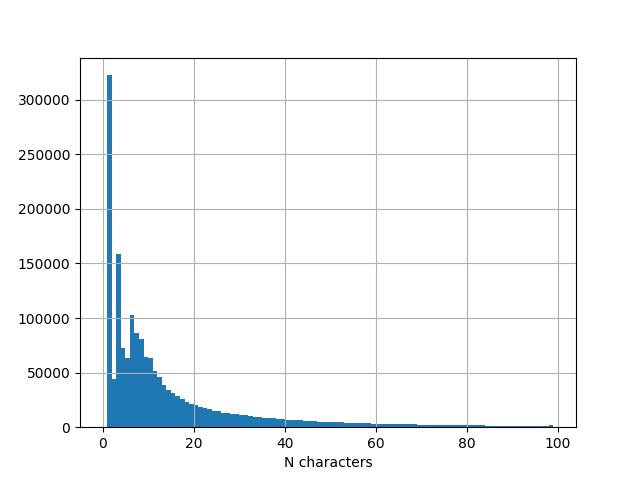

Text(0.5, 0, 'N characters')

In [62]:
eq_df.equation.apply(len).hist(bins=np.arange(0,100))
plt.xlabel('N characters')

In [68]:
keep_condition = (
    (eq_df.equation.apply(len) > 2) &
    (eq_df.equation.apply(len)<64)
    # (eq_df.equation.apply(lambda x: '\\ce' not in x))
)
keep_condition.mean()


0.7390135561989998

In [69]:
eq_df[keep_condition].to_csv(processed_dirname/'equations.csv', index=False)
